# Modelling

In [244]:
import pandas as pd
import numpy as np
import datetime
import time

%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

# from imblearn.over_sampling import SMOTE # to handle class imbalance NOT WORKING
import sklearn.cluster
import sklearn.manifold

# from imblearn.over_sampling import SMOTE


AttributeError: type object 'sklearn.manifold._barnes_hut_tsne.array' has no attribute '__reduce_cython__'

In [90]:
fulldata = pd.read_csv("../data/data_input_for_model.csv")
# fulldata.drop('Unnamed: 0', axis=1, inplace=True)

# lets remove 2012, as it is the first year, it has no "had_violation_lastyear"
fulldata = fulldata[fulldata.year > 2012]

fulldata.head().T

,1,2,3,4,5
pwsid,CT0010024,CT0010024,CT0010024,CT0010024,CT0010024
pws_name,ANDOVER TOWN HALL & FIRE DEPARTMENT,ANDOVER TOWN HALL & FIRE DEPARTMENT,ANDOVER TOWN HALL & FIRE DEPARTMENT,ANDOVER TOWN HALL & FIRE DEPARTMENT,ANDOVER TOWN HALL & FIRE DEPARTMENT
primacy_agency_code,CT,CT,CT,CT,CT
pws_type_code,TNCWS,TNCWS,TNCWS,TNCWS,TNCWS
gw_sw_code,GW,GW,GW,GW,GW
owner_type_code,P,P,P,P,P
population_served_count,25,25,25,25,25
primary_source_code,GW,GW,GW,GW,GW
is_wholesaler_ind,N,N,N,N,N
is_school_or_daycare_ind,N,N,N,N,N


In [95]:
# select features for modelling
features = ['primacy_agency_code', 'pws_type_code',
           'gw_sw_code', 'owner_type_code', 'population_served_count',
           'primary_source_code', 'is_wholesaler_ind', 'is_school_or_daycare_ind',
           'service_connections_count',
           'year', 
            'had_violation_lastyear', 
            'had_violation', 
           'had_pesticide_violation',
           'had_pesticide_violation_lastyear']
data = fulldata[features]

In [96]:
# get dummies:
# (on the contrary to R, this is needed in python as it is not done automatically by the fitting function)
data = pd.get_dummies(data)

Only three variables seem to have a some correlation with the outcome (*had_violation* or *had_pesticide_violation*): *pws_type_code*, *year* and especially *had_violation_lastyear*.

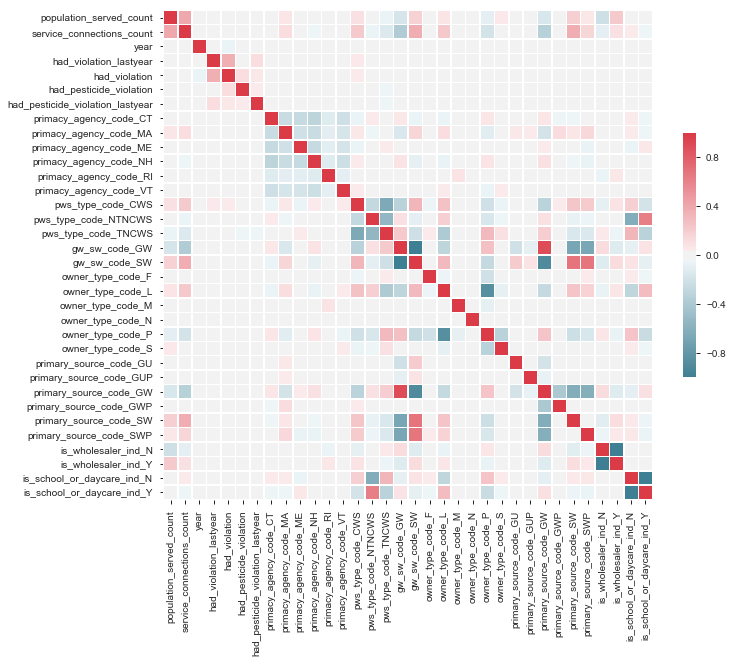

In [97]:
corr = data.corr() 

# heatmap of correlations:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True) # Generate a custom diverging colormap
# Draw the heatmap with the correct aspect ratio:
sns.heatmap(corr, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

We can get rid of some variables that are autocorrelated:

In [169]:
# gw_sw_code_GW and gw_sw_code_SW, as they are highly correlated with primary_source_code and less precise,
# and is_wholesaler_ind_N and is_school_or_daycare_ind_N, as they are binary and thus
# highly correlated with their Y complement.

data.drop(['gw_sw_code_GW', 'gw_sw_code_SW', 'is_wholesaler_ind_N', 'is_school_or_daycare_ind_N'], 
          axis=1, inplace=True)


## Standardizing the Data

We will do a _0-1 scaling_: 0-1 scaling: (Value - min Value)/(max Value - min Value).


In [174]:
data_std = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

In [175]:
data_std.year.unique()

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

## Trying First a Model to Predict All Violations (no focus on pesticides)

Using *had_violation* as outcome variable.

### Splitting in Train, Validation and Test Sets
We use the years 2013 to 2016 as train set, the year 2017 as validation set and the year 2018 as test set.

In [176]:
# SPLITTING IN TRAIN AND TEST:

# let's train to test data on 2013-2017 and predict 2017:
data_train = data_std[data_std.year < 0.8] # 2013, 2014, 2015, 2016
data_valid = data_std[data_std.year == 0.8] # 2017
data_test = data_std[data_std.year > 1.] # 2018

X_train = data_train.drop('had_violation', axis=1)
X_valid = data_valid.drop('had_violation', axis=1)
X_test = data_test.drop('had_violation', axis=1)

y_train = data_train.had_violation
y_valid = data_valid.had_violation
y_test = data_test.had_violation


### Training a Vanilla Logistic Regression

I would like to use _statsmodels_ to fit a logistic regression, as I want to learn about the importance of the different features, but I can not make it converge...

In [180]:
# ISSUE: CANNOT MAKE STATSMODELS CONVERGE...

# logit_model = sm.Logit(y_train, X_train)
# result = logit_model.fit_regularized() # even when changing fitting method='newton', 'bfgs', 'nm'
# print(result.summary2())

### First Training a Logistic Regression with Ridge Regularization (L2)

This is a first try to evaluate if the model has some accuracy and what are the potential issues and important features.

In [181]:
# first grid search to optimize C (lambda)
ridge = LogisticRegression(penalty='l2', solver='liblinear') # liblinear is good for small datasets
parameter = {'C':[0.1, 1, 10, 100, 1000, 10000]} 
# 5-fold CV and grid search to find the best C:
ridge_f = GridSearchCV(estimator=ridge, scoring='accuracy', param_grid=parameter, cv=5)
ridge_f.fit(X_train, y_train) # this is done -implicitely- with the best_estimator_ found with GridSearchCV
print('Best C:',ridge_f.best_estimator_.C) 
print('The mean cross-validated score of the best_estimator on X_train:', ridge_f.best_score_)
print('Accuracy on (full) X_train: ' + str(ridge_f.score(X_train, y_train)))


Best C: 0.1
The mean cross-validated score of the best_estimator on X_train: 0.891772514564034
Accuracy on (full) X_train: 0.8925842803934677


In [182]:
# second grid search based on previous best C:
parameter = {'C':[0.001, 0.01, 0.1, 0.5]} 
# 5-fold CV and grid search to find the best C:
ridge_f = GridSearchCV(estimator=ridge, scoring='accuracy', param_grid=parameter, cv=5)
ridge_f.fit(X_train, y_train) # this is done -implicitely- with the best_estimator_ found with GridSearchCV
print('Best C:',ridge_f.best_estimator_.C) 
print('The mean cross-validated score of the best_estimator on X_train:', ridge_f.best_score_)
print('Accuracy on (full) X_train: ' + str(ridge_f.score(X_train, y_train)))


Best C: 0.001
The mean cross-validated score of the best_estimator on X_train: 0.8918680164263203
Accuracy on (full) X_train: 0.8918680164263203


In [183]:
# final gridsearch, to refine a bit C:
parameter = {'C':[0.05, 0.1, 0.15]} 
# 5-fold CV and grid search to find the best C:
ridge_f = GridSearchCV(estimator=ridge, scoring='accuracy', param_grid=parameter, cv=5)
ridge_f.fit(X_train, y_train) # this is done -implicitely- with the best_estimator_ found with GridSearchCV
print('Best C:',ridge_f.best_estimator_.C) 
print('The mean cross-validated score of the best_estimator on X_train:', ridge_f.best_score_)
print('Accuracy on (full) X_train: ' + str(ridge_f.score(X_train, y_train)))
print('SD of mean test score (1 per parameter:) ' + str(ridge_f.cv_results_['std_test_score']))
# ridge_f.cv_results_ # to see more results

Best C: 0.05
The mean cross-validated score of the best_estimator on X_train: 0.8923694012033234
Accuracy on (full) X_train: 0.8924410276000382
SD of mean test score (1 per parameter:) [0.00417732 0.00444578 0.01826906]


Overfitting seems to be ok. Let's evaluate this model a bit more in detail:  

In [201]:
# Fitting the model with the chosen regularization:
logit_ridge = LogisticRegression(penalty='l2', solver='liblinear', C=0.1)
logit_ridge.fit(X_train, y_train)

# A way to estimate the most important features:
print(np.exp([np.std(X_train, 0)]*logit_ridge.coef_)) # "standardized" odds ratios. 
# They are around 1, but there is not confidence interval
# The fourth is high and is likely a very important feature.
# Without surprise, it is: had_violation_lastyear

[[0.99949306 0.99807062 0.92770937 2.05417693 1.09780444 1.00242941
  0.92885852 0.8977913  0.98320752 0.84361258 0.92277176 0.99313971
  0.91037885 0.81854474 0.74927566 0.9584949  0.84747386 0.99390964
  1.0018217  0.87249161 0.9682501  1.00478694 0.99809499 0.95696316
  0.93908557 0.96896288 0.94518642 0.9947742  1.00365646]]


#### Model Evaluation

Is the model overfitting? Is the accuracy obtained any good? What are the precision and recall?

In [197]:
# Overfitting:
cross_val_score(logit_ridge, X_train, y_train, cv=10) # looks not too bad.

array([0.89066603, 0.89353068, 0.89400812, 0.89257579, 0.88374314,
       0.8930277 , 0.89207259, 0.89183381, 0.89040115, 0.86792453])

In [205]:
print(classification_report(y_train, y_pred))
# precision: the ability of the classifier not to label as positive a sample that is negative
# recall: the ability of the classifier to find all the positive samples

              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94     37355
         1.0       0.53      0.06      0.11      4529

   micro avg       0.89      0.89      0.89     41884
   macro avg       0.71      0.53      0.53     41884
weighted avg       0.86      0.89      0.85     41884



We can see that the classifier is good at identifying water systems that did not have any violations, but is bad at identifying water systems that had violations (recall = 0.06, should be ideally close to 1).  
Is an accuracy around 89% impressive in this case?

In [213]:
n = data_std.had_violation.value_counts()
print(n)
print('baseline performance (across years) = percentage of WS without violations: ' + str(n[0]/(n[0]+n[1])) + '%')


0.0    56697
1.0     6129
Name: had_violation, dtype: int64
baseline performance (across years) = percentage of WS without violations: 0.9024448476745297%


Not at all! As around 10% of the samples never had any violations, thus it is expected that the baseline performance of any classification algorithm is around 90% (not on one year, but all the years).  

The model is bad at identifying the "new" water systems that will have a violation in the current year (except for those that add a violation in previous year).

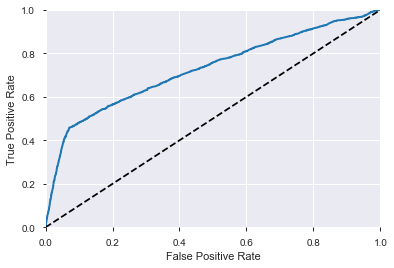

In [218]:
# one more way of evaluating the model, the ROC curve:


y_scores = logit_ridge.decision_function(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [219]:
# Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores:
roc_auc_score(y_train, y_scores) 


0.7266191413747641

## Handling Class Imbalance

Before trying different models and select one and trying to perfect our prediction (especially recall), we have to handle the large class imbalance in the data. It has to be done before, as it can have a different influence on the model that we will test after.  

We will try SMOTE to balance the data. Oversampling has to be done on training data alone ([see comment])(https://beckernick.github.io/oversampling-modeling). Oversampling can lead to bad generalization, that is why we will test the generalizibility on a validation set.

In [245]:
# adapt this: https://www.kaggle.com/qianchao/smote-with-imbalance-data

# TO DO

1. handle class imbalance
2. try a few model, evaluate, compare, select then fit on test set.
3. Discuss why the prediction is not so great, propose potential solutions
3. eventually try with had_pesticides and add pesticide use by county in the model.